# Implementation of Circuits From arxiv 2011.09692

In [103]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.visualization import *
from qiskit.circuit.library import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import collections
import typing

%matplotlib inline
Array = np.ndarray

## Quantum Teleportation Circuit (Fig. 1)

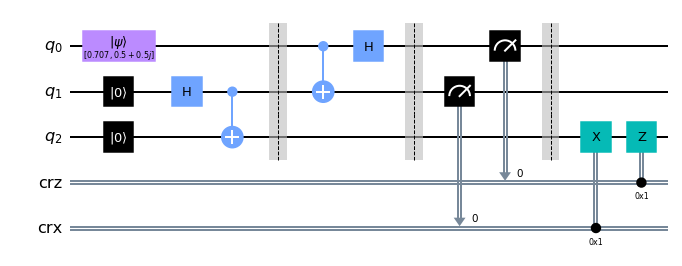

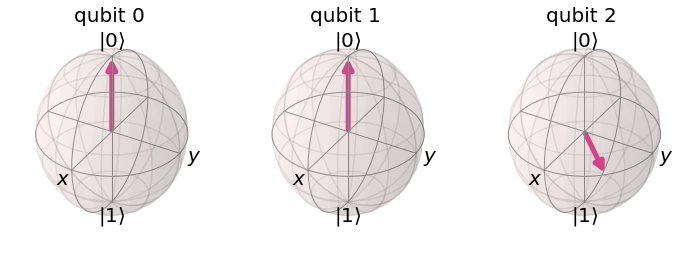

In [104]:
def teleporter(phi: Array):
    assert phi.shape[0] == 2, "initialized state must have 2 entries (single qubit)"
    qr = QuantumRegister(3, 'q')
    crz = ClassicalRegister(1, 'crz')
    crx = ClassicalRegister(1, 'crx')
    circ = QuantumCircuit(qr, crz, crx)
    
    circ.reset(qr[1])
    circ.reset(qr[2])
    
    circ.h(qr[1])
    circ.cx(qr[1], qr[2])
    
    circ.initialize(phi, qr[0])
    
    circ.barrier()
    
    circ.cx(qr[0], qr[1])
    circ.h(qr[0])
    
    circ.barrier()
    
    circ.measure(qr[1], crx)
    circ.measure(qr[0], crz)   
    
    circ.barrier()
    
    circ.x(qr[2]).c_if(crx, 1)
    circ.z(qr[2]).c_if(crz, 1)
    
    return circ

sv_simulator = Aer.get_backend('statevector_simulator')
# Let's teleport the state 1/sqrt(2) [1, exp(i pi / 4)]
phi = np.array([1/np.sqrt(2), 1/np.sqrt(2) * np.exp(1j * np.pi / 4)])
circ = teleporter(phi)

display(circ.draw('mpl'))

result = execute(circ, sv_simulator).result()
display(plot_bloch_multivector(result.get_statevector(circ, decimals = 3)))

## Key Update Algorithm (Fig. 2)

In [105]:
def key_update(a: int, b: int, c: int, d: int):
    assert all(0 <= x <= 1 for x in [a,b,c,d]), "inputs must be an integer modulo 2"
    return {'H': f'{b}{a}', 'X': f'{a}{b}', 'Z': f'{a}{b}', 'S': f'{a}{a ^ b}', 'cX': f'{a}{b ^ d}{a ^ c}{d}'}

df = []

for a in (0, 1):
    for b in (0, 1):
        for c in (0, 1):
            for d in (0, 1):
                update = key_update(a, b, c, d)
                update['abcd'] = f'{a}{b}{c}{d}'
                df.append(update)

df = pd.DataFrame(df)    
df.set_index('abcd', inplace = True)
print(df)

       H   X   Z   S    cX
abcd                      
0000  00  00  00  00  0000
0001  00  00  00  00  0101
0010  00  00  00  00  0010
0011  00  00  00  00  0111
0100  10  01  01  01  0100
0101  10  01  01  01  0001
0110  10  01  01  01  0110
0111  10  01  01  01  0011
1000  01  10  10  11  1010
1001  01  10  10  11  1111
1010  01  10  10  11  1000
1011  01  10  10  11  1101
1100  11  11  11  10  1110
1101  11  11  11  10  1011
1110  11  11  11  10  1100
1111  11  11  11  10  1001


## QPCE Algorithm

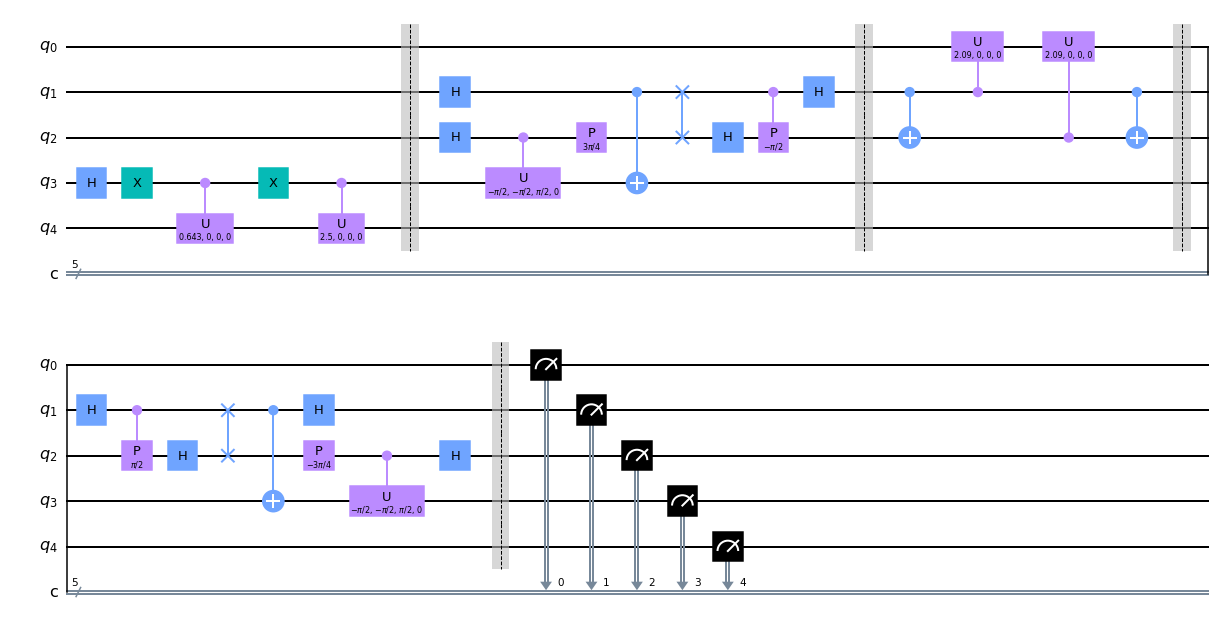

In [129]:
# rho = 1/2 * np.array([[1,3], [3, 1]])
# tau = 0.8
qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(5, 'c')
qpce = QuantumCircuit(qr, cr)
# prepare the state
theta1, theta2, alpha = 0.643, 2.498, 2.094
qpce.h(qr[3])
qpce.x(qr[3])
qpce.cu(theta1, 0, 0, 0, qr[3], qr[4])
qpce.x(qr[3])
qpce.cu(theta2, 0, 0, 0, qr[3], qr[4])
qpce.barrier()
# phase estimation
qpce.h(qr[1])
qpce.h(qr[2])
qpce.cu(-np.pi/2, -np.pi/2, np.pi/2, 0, qr[2], qr[3])
qpce.p(3*np.pi/4, qr[2])
qpce.cx(qr[1], qr[3])
qpce.swap(qr[1], qr[2])
qpce.h(qr[2])
qpce.cp(-np.pi/2, qr[1], qr[2])
qpce.h(qr[1])
qpce.barrier()
# Controlled rotation
qpce.cx(qr[1], qr[2])
qpce.cu(alpha, 0, 0, 0, qr[1], qr[0])
qpce.cu(alpha, 0, 0, 0, qr[2], qr[0])
qpce.cx(qr[1], qr[2])
qpce.barrier()
# Inverse phase estimation
qpce.h(qr[1])
qpce.cp(np.pi/2, qr[1], qr[2])
qpce.h(qr[2])
qpce.swap(qr[1], qr[2])
qpce.cx(qr[1], qr[3])
qpce.h(qr[1])
qpce.p(-3*np.pi/4, qr[2])
qpce.cu(-np.pi/2, -np.pi/2, np.pi/2, 0, qr[2], qr[3])
qpce.h(qr[2])
qpce.barrier()
# Measurement
qpce.measure(qr[0], cr[0])
qpce.measure(qr[1], cr[1])
qpce.measure(qr[2], cr[2])
qpce.measure(qr[3], cr[3])
qpce.measure(qr[4], cr[4])

qpce.draw('mpl')

In [130]:
qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute(qpce, qasm_simulator, shots=2048).result()

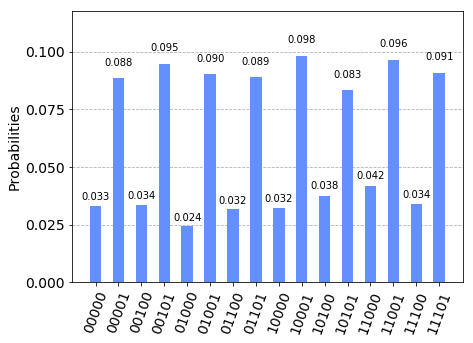

In [131]:
display(plot_histogram(result.get_counts()))

## The Key Update With Multiple T Gates

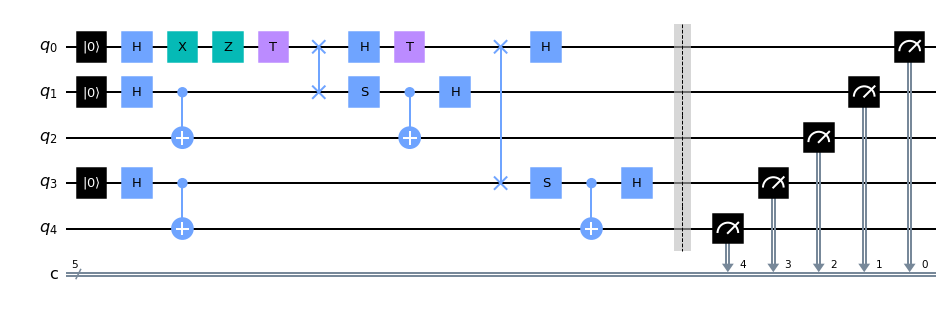

In [132]:
# The operation is HTHT
# a0, b0 = 1, 1
qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(5, 'c')
qku = QuantumCircuit(qr, cr)
# initialize
qku.reset(qr[0])
qku.reset(qr[1])
qku.reset(qr[3])
qku.h(qr[0])
qku.h(qr[1])
qku.h(qr[3])
qku.x(qr[0])
qku.cx(qr[1], qr[2])
qku.cx(qr[3], qr[4])
qku.z(qr[0])
qku.t(qr[0])
qku.swap(qr[0], qr[1])
qku.h(qr[0])
qku.s(qr[1])
qku.t(qr[0])
qku.cx(qr[1], qr[2])
qku.h(qr[1])
qku.swap(qr[0], qr[3])
qku.h(qr[0])
qku.s(qr[3])
qku.cx(qr[3], qr[4])
qku.h(qr[3])

qku.barrier()
qku.measure(qr[4], cr[4])
qku.measure(qr[3], cr[3])
qku.measure(qr[2], cr[2])
qku.measure(qr[1], cr[1])
qku.measure(qr[0], cr[0])

qku.draw('mpl')

In [133]:
result = execute(qku, qasm_simulator, shots=2048).result()

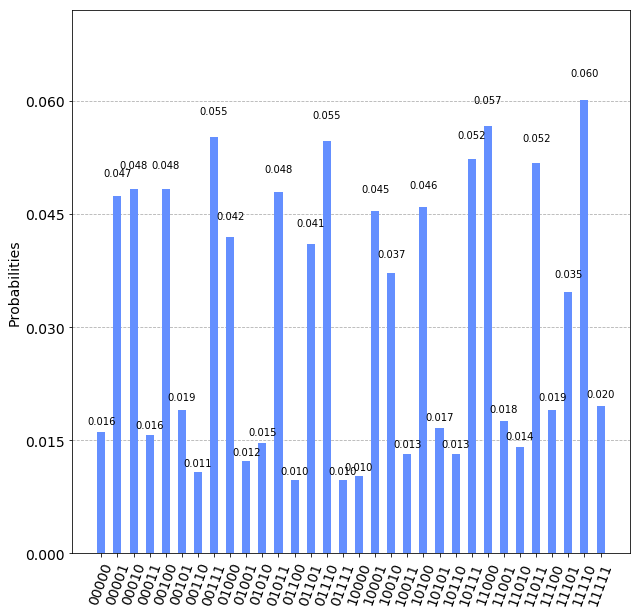

In [134]:
display(plot_histogram(result.get_counts(), figsize=(10,10)))

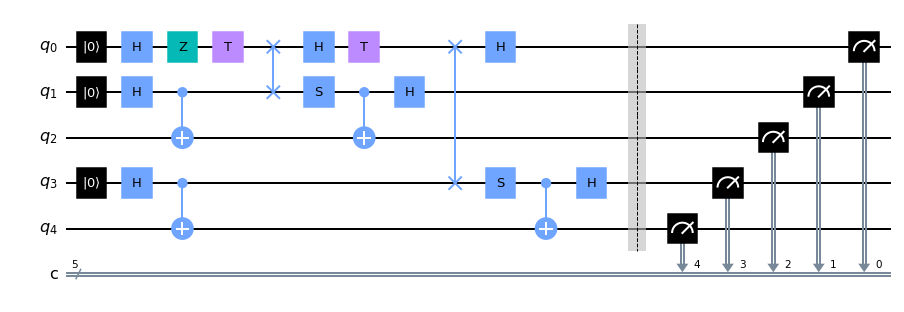

In [135]:
# The operation is HTHT
# a0, b0 = 0, 1
qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(5, 'c')
qku = QuantumCircuit(qr, cr)
# initialize
qku.reset(qr[0])
qku.reset(qr[1])
qku.reset(qr[3])
qku.h(qr[0])
qku.h(qr[1])
qku.h(qr[3])
# qku.x(qr[0]) a = 0
qku.cx(qr[1], qr[2])
qku.cx(qr[3], qr[4])
qku.z(qr[0])
qku.t(qr[0])
qku.swap(qr[0], qr[1])
qku.h(qr[0])
qku.s(qr[1])
qku.t(qr[0])
qku.cx(qr[1], qr[2])
qku.h(qr[1])
qku.swap(qr[0], qr[3])
qku.h(qr[0])
qku.s(qr[3])
qku.cx(qr[3], qr[4])
qku.h(qr[3])

qku.barrier()
#ra(2)
qku.measure(qr[4], cr[4])
#rb(2)
qku.measure(qr[3], cr[3])
#ra(1)
qku.measure(qr[2], cr[2])
#rb(1)
qku.measure(qr[1], cr[1])
#q0
qku.measure(qr[0], cr[0])

qku.draw('mpl')

In [136]:
result = execute(qku, qasm_simulator, shots=2048).result()

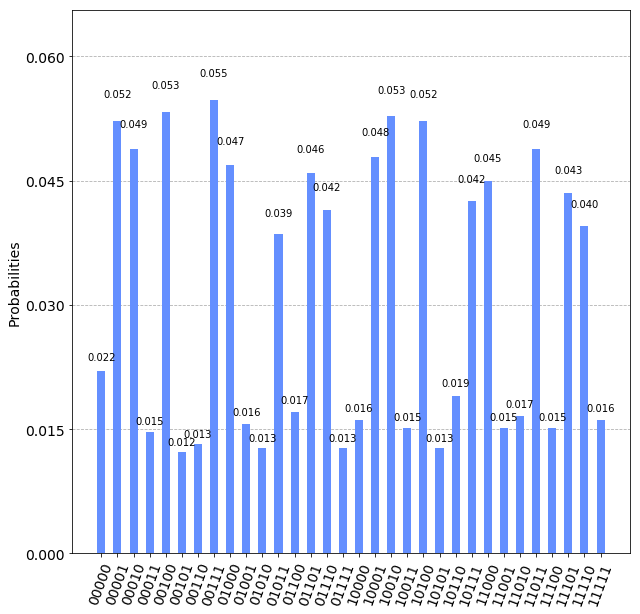

In [137]:
display(plot_histogram(result.get_counts(), figsize=(10,10)))

In [151]:
# Select 4 measurements with high probability, here we choose > 0.05
import random
sample = []
counts = list(result.get_counts().items())
total = sum(x for _, x in counts)
while len(sample) < 4:
    state, count = counts[random.randint(0,len(counts)-1)]
    if count / total >= 0.05:
        sample.append(state)
print(sample)


['10010', '00001', '10010', '00111']


In [155]:
a0, b0 = 0, 1
for state in sample:
    ra2, rb2, ra1, rb1, q0 = [int(c) for c in state]
    af = b0 ^ ra1 ^ rb1 ^ rb2
    bf = a0 ^ b0 ^ rb1 ^ ra2
    print(f'Measurements are {state}')
    print(f'Final decyption keys: {af}, {bf}')
    print(f'Final state measurement: {q0}')
    
# here we find the opposite of the researchers result, where if af = 0 we measure q0 = 0 and if af = 1 we measure q0 = 1

Measurements are 10010
Final decyption keys: 0, 1
Final state measurement: 0
Measurements are 00001
Final decyption keys: 1, 1
Final state measurement: 1
Measurements are 10010
Final decyption keys: 0, 1
Final state measurement: 0
Measurements are 00111
Final decyption keys: 1, 0
Final state measurement: 1
